<a href="https://colab.research.google.com/github/IrisFDTD/AI-UNIZAR-course/blob/main/recurrent_networks/ai_unizar_course_recurrent_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">*Introducción a la inteligencia artificial: redes neuronales avanzadas con Tensorflow-Keras*</span> por <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Sergio Gutiérrez Rodrigo (sergut@unizar.es)</span> se distribuye bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Licencia Creative Commons Atribución-NoComercial-CompartirIgual 4.0 Internacional</a>.

```
Sergio G Rodrigo
Departamento de Física Aplicada
Universidad de Zaragoza
Instituto de Nanociencia y Materiales de Aragón (INMA)
C/ Pedro Cerbuna, 12, 50009, Zaragoza, España
```






# **Advanced Neural Networks with TensorFlow-Keras**

---
# **Time Series Prediction with Recurrent Neural Networks (RNN)**
---


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Auxiliary functions

In [ ]:
def plot_history(history):
    train_loss = history.history['loss']
    epochs = range(1, len(train_loss) + 1)

    # Extract the validation loss values
    val_loss = history.history['val_loss']

    # Plot the training loss and validation loss vs. epoch
    plt.rcParams.update({'font.size': 14})
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    pass


def plot_time_series(x,y_true,model,model_name):
    # Create the plot
    j=np.random.randint(x.shape[0])

    n_steps=x.shape[1]
    print(n_steps)
    time=list(range(1, n_steps + 1))

    pred=model.predict(x[j].reshape(1, n_steps, 1))
    print(pred.shape)
    final_step=pred.shape[1]
    series=x[j]
    true=y_true[j][0:final_step]

    pred=np.squeeze(pred)
    true=np.squeeze(true)

    time_pred=np.arange(n_steps + 1,n_steps + 1+final_step)

    print("MSE=",tf.keras.losses.mean_squared_error([true],[pred]).numpy())

    plt.rcParams.update({'font.size': 14})
    plt.plot(time,series,label='data',marker='o',markersize=5)
    plt.plot(time_pred,true,'ro',label='target')
    plt.plot(time_pred,pred,'x',color='black',label=model_name)
    plt.xlabel(r'$t$ (time in a.u.)')
    plt.ylabel(r'$s(t)$')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)
    # Show the plot
    plt.show()
    pass

# Generating time series: toy model

$s(t)$ signal as a function of time = two sinusoidal waves + noise
---

$s(t)=\dfrac{1}{2}\sin[(t-\phi_1)(10\omega_1+10)]+\dfrac{1}{5}\sin[(t-\phi_2)(20\omega_2+20)]+noise$

where:
+ $\omega_1, \omega_2, \phi_1, \phi_2 \in [0,1]$
+ $\Delta t=\dfrac{1}{n_{steps}}=\frac{1}{60}$
+ $noise \in [-0.05,0.05]$

In [ ]:
def generate_time_series(batch_size, n_steps):
  '''
  Return 4 vectors of random numbers of length batch_size
  '''
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0, 1, n_steps)
  series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
  series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
  return series[..., np.newaxis].astype(np.float32)

In [ ]:
# Generate time series: n_steps for training and n_target as targets
n_steps = 50
n_target = 10
N_series=1000
N_train=700
N_val=200
N_test=100

series = generate_time_series(N_series, n_steps + n_target)
print("Time series shape (batch_size,time steps,number of features)=",series.shape)

X_train, Y_train = series[:N_train, :n_steps], series[:N_train, -n_target:, 0]
X_val, Y_val = series[N_train:N_train+N_val, :n_steps], series[N_train:N_train+N_val, -n_target:, 0]
X_test, Y_test = series[N_series-N_test:, :n_steps], series[N_series-N_test:, -n_target:, 0]

In [ ]:
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape,Y_test.shape)

## Plot example

In [ ]:
j=np.random.randint(X_test.shape[0])
print('j=',j)
plt.rcParams.update({'font.size': 14})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data',marker='o',markersize=5)
plt.plot(list(range(n_steps + 1,n_steps + 11)),Y_test[j],'ro',label='targets')
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)
# Show the plot
plt.show()

# **Predicting next time step of the time series**

# Baseline (naive prediction): predicting the next time step



In [ ]:
#BASELINE1
#we predict the last value from each series
y_pred = X_test[:, -1]
print("y_pred baseline shape=",y_pred.shape)
print('MSE: ')
np.mean(tf.keras.losses.mean_squared_error(Y_test, y_pred))

In [ ]:
j=np.random.randint(X_test.shape[0])
plt.rcParams.update({'font.size': 14})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data',marker='o',markersize=5)
plt.plot(list(range(n_steps + 1,n_steps + 2)),y_pred[j],'ro',label='baseline')
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)
# Show the plot
plt.show()

# **Single Neuron**

## Dense Neural Network (DNN)

In [ ]:
model1 = tf.keras.models.Sequential([
tf.keras.layers.Flatten(input_shape=[50, 1]),
tf.keras.layers.Dense(1)
])

model1.summary()
model1.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history1=model1.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))


In [ ]:
ypred=model1.predict(X_test)
np.mean(tf.keras.losses.mean_squared_error(Y_test, ypred))

In [ ]:
plot_history(history1)

In [ ]:
plot_time_series(X_test,Y_test,model=model1,model_name='FF neuron')

## Recurrent Neural Network (RNN)


Parameters per layer:
+ $W_x=n_{inputs} \times n_{neurons}$
+ $W_y=n_{neurons} \times n_{neurons}$
+ $b= n_{neurons}$

### Simple RNN

In [ ]:
'''
By deafault, it will only return the last output, hyperbolic tangent activation
initial sate is set to 0.

We do not need to specify the length of the
input sequences (unlike in the previous model), since a recurrent neural network can
process any number of time steps (this is why we set the first input dimension to None)
'''
model2 = tf.keras.models.Sequential([
tf.keras.layers.SimpleRNN(1, input_shape=(None, 1))])
model2.summary()

In [ ]:
model2.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history2=model2.fit(X_train, Y_train[:,0],
                    epochs=40,
                    validation_data=(X_val, Y_val[:,0]))

In [ ]:
ypred=model2.predict(X_test)
np.mean(tf.keras.losses.mean_squared_error(Y_test[:,0], ypred))

In [ ]:
plot_history(history2)

In [ ]:
plot_time_series(X_test,Y_test,model=model2,model_name='Simple RNN')

### Custom Simple RNN code

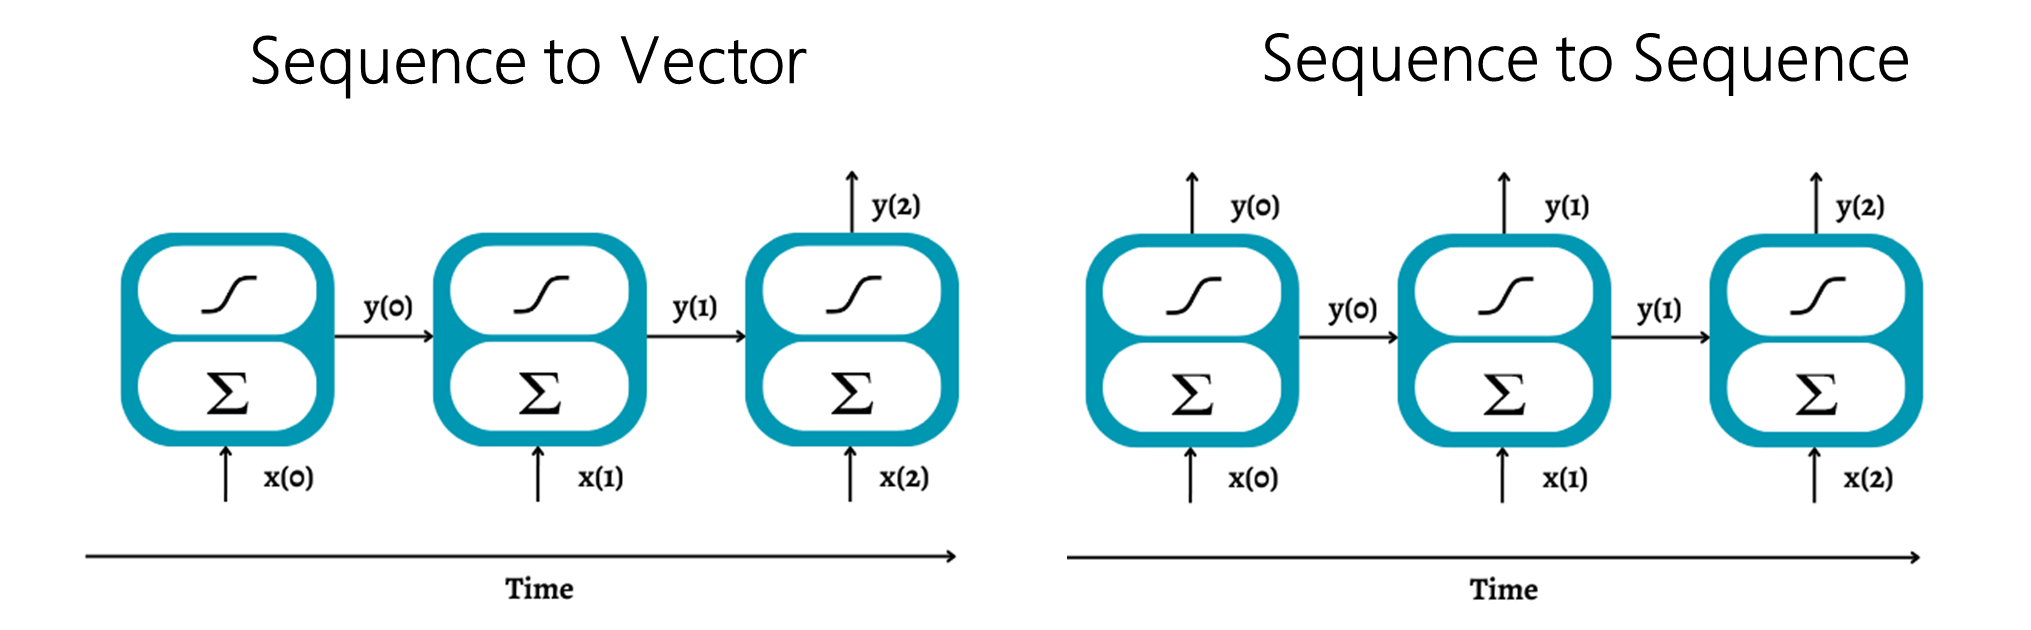

In [ ]:
# Will take the weights from the SimpleRNN model
model2.weights

In [ ]:
import numpy as np
# Take a random series from X_test
j=np.random.randint(X_test.shape[0])
inputs =X_test[j]

# Input_features and output_feauteres of the RNN cell
input_features = 1
output_features = 1

# Initial state of the RNN cell
state_t = np.zeros((output_features,))

# Weights and bias
W=model2.weights[0].numpy() # Regular kernel
U=model2.weights[1].numpy() # Recurrent Kernel
b=model2.weights[2].numpy() # bias

# List to add the successive outputs
successive_outputs = []

# Recurrent loop: for every time step (input_t) y produces the output_t
# that is appended into a list
# The state is updated in each iteration
for input_t in inputs:
  #print("input t=",input_t)
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
  #print("output t=",output_t)
  successive_outputs.append(output_t)
  state_t = output_t

# Get the final output sequence
print("successive output length=",len(successive_outputs))
final_output_sequence = np.concatenate(successive_outputs, axis=0)

# Predictions
pred_naive=final_output_sequence
pred_keras_SimpleRNN=model2.predict(X_test)[j]
print("Custom SimpleRNN prediction shape=",pred_naive.shape)
print("Keras SimpleRNN shape=",pred_keras_SimpleRNN.shape)

# Plot
plt.plot(inputs,label='data')
plt.scatter(51,pred_keras_SimpleRNN,label='Simple RNN',color='green',marker='o',s=80)
plt.scatter(51,pred_naive[-1],label='Custom Simple RNN',color='red',marker='X',s=50)
plt.plot(pred_naive,label='Sequence (outputs)')
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.grid(True)
plt.show()

### LSTM

In [ ]:
'''
By deafault, it will only return the last output, hyperbolic tangent activation
initial sate is set to 0

We do not need to specify the length of the
input sequences (unlike in the previous model), since a recurrent neural network can
process any number of time steps (this is why we set the first input dimension to None)
'''
model3 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(1, input_shape=(None, 1))])

model3.summary()

In [ ]:
model3.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history3=model3.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

In [ ]:
ypred=model3.predict(X_test)
np.mean(tf.keras.losses.mean_squared_error(Y_test, ypred))

In [ ]:
plot_history(history3)

In [ ]:
plot_time_series(X_test,Y_test,model=model3,model_name='LSTM cell')

### GRU

In [ ]:
model4 = tf.keras.models.Sequential([
tf.keras.layers.GRU(1, input_shape=(None, 1))])

model4.summary()

In [ ]:
model4.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history4=model4.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

In [ ]:
ypred=model4.predict(X_test)
np.mean(tf.keras.losses.mean_squared_error(Y_test, ypred))

In [ ]:
plot_history(history4)

In [ ]:
plot_time_series(X_test,Y_test,model=model4,model_name='GRU cell')

# **Deep Neural Networks**

### Dense Neural Network (DNN)

In [ ]:
model5 = tf.keras.models.Sequential([
tf.keras.layers.Flatten(input_shape=[50, 1]),
tf.keras.layers.Dense(20),
tf.keras.layers.Dense(20),
tf.keras.layers.Dense(1)
])

model5.summary()

In [ ]:
model5.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history5=model5.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

In [ ]:
ypred=model5.predict(X_test)
np.mean(tf.keras.losses.mean_squared_error(Y_test, ypred))

In [ ]:
plot_history(history5)

In [ ]:
plot_time_series(X_test,Y_test,model=model5,model_name='DNN')

## Recurrent Neural Networks (RNN)

###Simple RNN

Parameters per layer:
+ $W_x=n_{inputs} \times n_{neurons}$
+ $W_y=n_{neurons} \times n_{neurons}$
+ $b= n_{neurons}$

In [ ]:
# Set return_sequences=True for all recurrent layers except the last one
model6 = tf.keras.models.Sequential([
tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=(None, 1)),
tf.keras.layers.SimpleRNN(20, return_sequences=True),
tf.keras.layers.SimpleRNN(1)
])

model6.summary()

In [ ]:
for layer in model6.layers:
  print("\n",layer.name)
  print("Layer input shape=",layer.input.shape)
  print("Layer output shape=",layer.output.shape)

In [ ]:
model6.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history6=model6.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

In [ ]:
ypred=model6.predict(X_test)
np.mean(tf.keras.losses.mean_squared_error(Y_test, ypred))

In [ ]:
plot_history(history6)

In [ ]:
plot_time_series(X_test,Y_test,model=model6,model_name='Deep RNN')

In [ ]:
model7 = tf.keras.models.Sequential([
tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=(None, 1)),
tf.keras.layers.SimpleRNN(20),
tf.keras.layers.Dense(1)
])

model7.summary()

In [ ]:
model7.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history7=model7.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

In [ ]:
plot_history(history7)

In [ ]:
plot_time_series(X_test,Y_test,model=model7,model_name='Deep RNN (output = dense layer)')

### LSTM

In [ ]:
model8 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(20, return_sequences=True, input_shape=(None, 1)),
tf.keras.layers.LSTM(20),
tf.keras.layers.Dense(1)
])

model8.summary()

In [ ]:
model8.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history8=model8.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

In [ ]:
plot_history(history8)

In [ ]:
plot_time_series(X_test,Y_test,model=model8,model_name='Deep LSTM')



### GRU

In [ ]:
model9 = tf.keras.models.Sequential([
tf.keras.layers.GRU(20, return_sequences=True, input_shape=(None, 1)),
tf.keras.layers.GRU(20),
tf.keras.layers.Dense(1)
])

model9.summary()

In [ ]:
model9.compile(loss='mse',
          optimizer='adam',
          metrics=['mae'])

history9=model9.fit(X_train, Y_train[:,0], epochs=40, validation_data=(X_val, Y_val[:,0]))

In [ ]:
plot_history(history9)

In [ ]:
plot_time_series(X_test,Y_test,model=model9,model_name='Deep LSTM')

# **Forecasting several time steps from a pre-trained RNN**

Options:
1.   **Iterative method**: Forecast the next step, add it to the timeseriries, and repeat
2.   **Sequence to vector**: predict the last timesteps (targets).
3.   **Sequence to sequence**: give all steps at once.

## Forecasting the next step iteratively


In [ ]:
model= model9 #Choose one of the previos already trained models

In [ ]:
# Prediction
n_pred=n_target
j = np.random.randint(0, len(Y_test))

sequence=X_test[j].reshape(1,X_train.shape[1], 1)
for i in range (0,n_pred):
  pred=model.predict(sequence[:,i:,:]) #predict next timestep with previous 1000 steps
  sequence=np.concatenate((sequence, pred.reshape(1, 1, 1)), axis=1) #add it to the sequence
prediction=sequence[0,n_steps:,:]
print(prediction)

In [ ]:
# Create the plot
j=np.random.randint(X_test.shape[0])
plt.rcParams.update({'font.size': 14})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data',marker='o',markersize=5)
plt.plot(list(range(n_steps + 1,n_steps + 11)),prediction,'x',color='black',label='Iterative')
plt.plot(list(range(n_steps + 1,n_steps + 11)),Y_test[j],'ro',label='targets')
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)
# Show the plot
plt.show()

## LSTM Sequence-to-Vector

In [ ]:
model10 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(20, return_sequences=True, input_shape=(None, 1)),
tf.keras.layers.LSTM(20),
tf.keras.layers.Dense(10)
])
model10.summary()

In [ ]:
model10.compile(loss='mse',
          optimizer='adam',
          metrics='mae')

history10=model10.fit(X_train, Y_train, epochs=40, validation_data=(X_val, Y_val))

In [ ]:
plot_history(history10)

In [ ]:
plot_time_series(X_test,Y_test,model=model10,model_name='LSTM Seq-to-Vec')

##LSTM Sequence-to-Sequence

### Generating data

In [ ]:
# Every target will contain n_steps vectors of dimension 10, each one shifted by 10 steps.
n_steps = 50
target_len=10

Y = np.empty((N_series, n_steps, target_len)) # each target is a sequence of 10D vectors

for step_ahead in range(1, target_len + 1):
  Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]

Y_train_s2s = Y[:N_train]
Y_val_s2s = Y[N_train:N_train+N_val]
Y_test_s2s = Y[N_train+N_val:]

In [ ]:
print("x_train shape=",X_train.shape)
print("y_train shape=",Y_train.shape)

# Create the plot
j=np.random.randint(X_test.shape[0])
plt.rcParams.update({'font.size': 14})
plt.plot(list(range(1, n_steps + 1)),X_test[j],color='black',label='data',markersize=10,marker='o')
for step_ahead in range(target_len,0,-1):#range(1, target_len + 1):
  plt.plot(list(range(1+step_ahead, step_ahead+n_steps+1)),Y_test_s2s[j,:,step_ahead-1],markersize=int(step_ahead),marker='o',label="step "+str(step_ahead))
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))
plt.grid(True)
#plt.legend()

# Show the plot
plt.show()

### The LSTM network


In [ ]:
model11 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(20, return_sequences=True, input_shape=(None, 1)),
tf.keras.layers.LSTM(20, return_sequences=True),
tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10))
])

model11.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model11.compile(loss="mse", optimizer=optimizer, metrics=['mae'])

In [ ]:
history11=model11.fit(X_train, Y_train_s2s, epochs=40, validation_data=(X_val, Y_val_s2s))

In [ ]:
plot_history(history11)

In [ ]:
# Create the plot
# Y_test = samples x time_steps x target_points
# Each Y_test[j] = time_steps x target_points
# Note that Y_test[j,:,i] is the function shifted i+1 steps ahead
# Y_test[j][-1] are the last target_points values of all the shifted functions

target_len=10
j=np.random.randint(X_test.shape[0])
pred=model11.predict(X_test[j].reshape(1, 50, 1))
print(X_test.shape)
print(Y_test_s2s.shape)
print(Y_test_s2s[j].shape)
print(pred.shape)
print(pred[0].shape)
plt.rcParams.update({'font.size': 14})
plt.plot(list(range(1, n_steps + 1)),X_test[j],label='data',marker='o',markersize=5)
plt.plot(list(range(n_steps + 1,n_steps + target_len+1)),Y_test_s2s[j][-1],'ro',label='target')
plt.plot(list(range(n_steps + 1,n_steps + target_len+1)),pred[0][-1],'x',color='black',label='LSTM Seq-to-Seq')
plt.xlabel(r'$t$ (time in a.u.)')
plt.ylabel(r'$s(t)$')
plt.grid(True)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2,fontsize=12)
# Show the plot
plt.show()
